# Simple Wind and Solar Hybrid Plant Example
---
In this example, we will walk through the process of simulating a hybrid renewable energy system using the Hybrid Optimization Performance Platform ([HOPP](https://github.com/NREL/HOPP)) library. We will simulate a hybrid system at a given location consisting of both wind and solar energy, and show how to access the simulation outputs.

### Import Required Modules
We start by importing the necessary modules and setting up our working environment.

In [1]:
from hopp.simulation.hybrid_simulation import HybridSimulation
from hopp.simulation.technologies.hydrogen.electrolysis import run_h2_PEM
import numpy as np
import matplotlib.pyplot as plt

/Users/egrant/Desktop/HOPP-GIT/HOPP/examples/workshop/log/hybrid_systems_2023-10-24T09.15.02.114335.log


### Set Site Information
Set wind and solar resource data at plant location. In this example, we use the Flatirons site as an example location.

In [2]:
from hopp import ROOT_DIR
from hopp.simulation.technologies.sites import SiteInfo, flatirons_site

DEFAULT_SOLAR_RESOURCE_FILE = ROOT_DIR.parent / "resource_files" / "solar" / "35.2018863_-101.945027_psmv3_60_2012.csv"
DEFAULT_WIND_RESOURCE_FILE = ROOT_DIR.parent / "resource_files" / "wind" / "35.2018863_-101.945027_windtoolkit_2012_60min_80m_100m.srw"


site = SiteInfo(
        flatirons_site,
        solar_resource_file=DEFAULT_SOLAR_RESOURCE_FILE,
        wind_resource_file=DEFAULT_WIND_RESOURCE_FILE,
        solar=True,
        wind=True,
        wave=False
    )

### Define System Capacities
Specify the capacities of the solar, wind, electrolyzer, and interconnection components of the hybrid system in megawatts (MW).

In [3]:
solar_size_mw = 50
wind_size_mw = 50
interconnection_size_mw = 50
electrolyzer_size_mw = 100

### Set electrolyzer and project parameters
in this example, we're simulating an off-grid electrolyzer system. We define 2 electrolyzer stacks, which will each be 50 MW. The other inputs are reasonable default values, and will be discussed further in future examples.

In [4]:
simulation_length = 8760 #1 year
plant_life = 30 #years
use_degradation_penalty=True
number_electrolyzer_stacks = 2
grid_connection_scenario = 'off-grid'
EOL_eff_drop = 10
pem_control_type = 'basic'
user_defined_pem_param_dictionary = {
    "Modify BOL Eff": False,
    "BOL Eff [kWh/kg-H2]": [],
    "Modify EOL Degradation Value": True,
    "EOL Rated Efficiency Drop": EOL_eff_drop,
}

### Define Renewable Technologies Configuration
Configure the characteristics of each technology in the system, including PV (solar), wind, and grid interconnection.

In [5]:
technologies = {
    'pv': {
        'system_capacity_kw': solar_size_mw * 1000
    },
    'wind': {
        'num_turbines': 10,
        'turbine_rating_kw': 5000
    },
    'grid': {
        'interconnect_kw': interconnection_size_mw * 1000
    }
}

### Create the Hybrid Simulation Model
Create an instance of the `HybridSimulation` class by providing the technology configuration and site information.

In [6]:
hybrid_plant = HybridSimulation(technologies, site)

### Run the Simulation
Simulate the hybrid renewable energy system for a specified number of years (in this case, 25 years).

In [7]:
hybrid_plant.simulate(plant_life)

### Retrieve power generation profile from wind and solar components

``solar_plant_power`` is the solar generation profile, and ``wind_plant_power`` is the wind generation profile. The total hybrid plant power generation (``hybrid_plant_generation_profile``) is the input power to the electrolyzer. These are in units of kWh.

In [8]:
solar_plant_power = np.array(hybrid_plant.pv.generation_profile[0:simulation_length])
wind_plant_power = np.array(hybrid_plant.wind.generation_profile[0:simulation_length])
hybrid_plant_generation_profile = solar_plant_power + wind_plant_power

### Run the electrolyzer

The key electrolyzer inputs are:
- ``hybrid_plant_generation_profile``: energy input to the electrolyzer
- ``electrolyzer_size_mw``: total installed electrolyzer capacity
- ``number_electrolyzer_stacks``: how many individual stacks make up the electrolyzer system.

The outputs are:
- ``h2_results``: aggregated performance information
- ``H2_Timeseries``: hourly time-series of hydrogen production and other key parameters
- ``H2_Summary``: averages or totals of performance data over the entire simulation
- ``energy_input_to_electrolyzer``: for this example (off-grid scenario), this is the same as ``hybrid_plant_generation_profile``.

In [9]:
h2_results, H2_Timeseries, H2_Summary,energy_input_to_electrolyzer =\
run_h2_PEM.run_h2_PEM(hybrid_plant_generation_profile,
electrolyzer_size_mw,
plant_life, number_electrolyzer_stacks,[],
pem_control_type,100,user_defined_pem_param_dictionary,
use_degradation_penalty,grid_connection_scenario,[])

Took 0.097 sec to run the create clusters
Took 0.056 sec to run even_split_power function
Took 0.064 sec to run the RUN function


### Get the time-series data and rated hydrogen production

In [10]:
# Total hydrogen output timeseries (kg-H2/hour)
hydrogen_production_kg_pr_hr = H2_Timeseries['hydrogen_hourly_production']
# Rated/maximum hydrogen production from electrolysis system
max_h2_pr_h2 = h2_results['new_H2_Results']['Rated BOL: H2 Production [kg/hr]']
#x-values as hours of year
hours_of_year = np.arange(0,len(hydrogen_production_kg_pr_hr),1)

### Specify hours to plot
We're only going to look at 72 hour frame of the results, starting at hour 2000.

In [11]:

hour_start = 2000
n_hours = 72
hour_end = hour_start + n_hours

### Plot results
The top plot shows the hydrogen produced (green solid line) with the rated hydrogen production indicated by a red dashed line.

The bottom plot shows the total energy input to the electrolyzer (green solid line) and the individual wind (blue dotted line) and solar (orange dashed line) generation profiles.

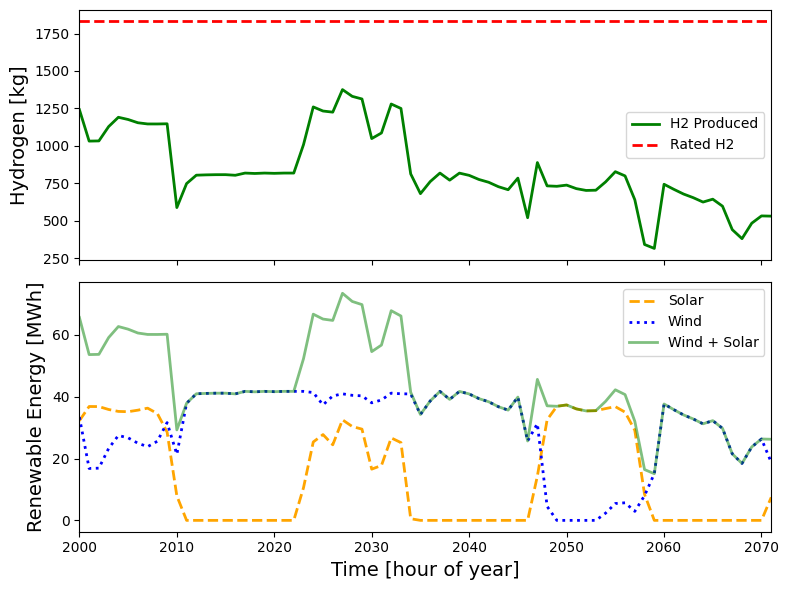

In [12]:

fig,ax=plt.subplots(2,1,sharex=True)
fig.set_figwidth(8.0)
fig.set_figheight(6.0)

ax[0].plot(hours_of_year[hour_start:hour_end],hydrogen_production_kg_pr_hr[hour_start:hour_end],lw=2,c='green',label='H2 Produced')
ax[0].plot(hours_of_year[hour_start:hour_end],max_h2_pr_h2*np.ones(n_hours),lw=2,ls='--',c='red',label='Rated H2')
ax[0].legend(loc='center right')
ax[0].set_ylabel('Hydrogen [kg]',fontsize=14)
ax[0].set_xlim((hour_start,hour_end-1))

ax[1].plot(hours_of_year[hour_start:hour_end],solar_plant_power[hour_start:hour_end]/1e3,lw=2,ls='--',c='orange',label='Solar')
ax[1].plot(hours_of_year[hour_start:hour_end],wind_plant_power[hour_start:hour_end]/1e3,lw=2,ls=':',c='blue',label='Wind')
ax[1].plot(hours_of_year[hour_start:hour_end],hybrid_plant_generation_profile[hour_start:hour_end]/1e3,lw=2,alpha=0.5,c='green',label='Wind + Solar')
ax[1].set_ylabel('Renewable Energy [MWh]',fontsize=14)
ax[1].set_xlabel('Time [hour of year]',fontsize=14)
ax[1].set_xlim((hour_start,hour_end-1))
ax[1].legend()
fig.tight_layout()